## ノートブック上で動かす

In [ ]:
!sudo pip install tensorflow-hub

In [1]:
import tensorflow as tf
from trainer import wgan_estimator

print(tf.__version__)

model_dir = "./model_dir/{}".format("003")
data_path = "gs://rosafune-gan-dataset1/animefaces-64/output-r06.tfrecords"
params = {
    "model_dir": model_dir,
    "generator_lr": 0.000076421,
    "discriminator_lr": 0.0031938,
    "batch_size": 32,
    "noise_dims": 64,
    "num_train_steps": 100, ## ここ増やす
    "num_eval_steps": 100,
    "data_path": data_path,
}

model = wgan_estimator.train_and_evaluate(params)


1.15.0

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_master': '', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f930dddee10>, '_protocol': None, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_num_worker_replicas': 1, '_is_chief': True, '_service': None, '_task_type': 'worker', '_task_id': 0, '_evaluation_master': '', '_experimental_max_worker_delay_secs': None, '_tf_random_seed': None, '_device_fn': None, '_log_step_count_steps': 100, '_save_summary_steps': 100, '_experimental_distribute': None, '_train_distribute': None, '_eval_distribute': None, '_model_dir': './model_dir/003', '_global_id_in_cluster': 0, '_session_creation_timeout_secs': 7200, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000}
INFO:tensorflow:Not using Distribute Coordinator

INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
INFO:tensorflow:Done calling model_fn.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model_dir/003/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


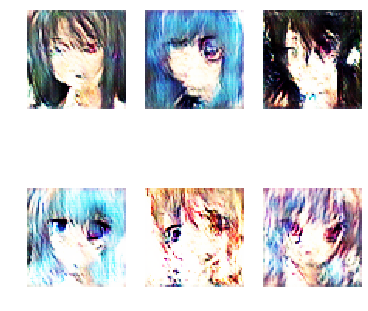

In [2]:
import numpy as np
import tensorflow as tf

yields_prediction = model.predict(lambda:wgan_estimator.input_fn(data_path, tf.estimator.ModeKeys.PREDICT, params))
predictions = np.array([next(yields_prediction) for _ in range(100)])

import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(6, 6), facecolor="w")
ax = fig.add_subplot(2, 3, 1)
ax.imshow(predictions[0])
ax.set_axis_off()

ax = fig.add_subplot(2, 3, 2)
ax.imshow(predictions[1])
ax.set_axis_off()

ax = fig.add_subplot(2, 3, 3)
ax.imshow(predictions[2])
ax.set_axis_off()

ax = fig.add_subplot(2, 3, 4)
ax.imshow(predictions[3])
ax.set_axis_off()

ax = fig.add_subplot(2, 3, 5)
ax.imshow(predictions[4])
ax.set_axis_off()

ax = fig.add_subplot(2, 3, 6)
ax.imshow(predictions[5])
ax.set_axis_off()

In [ ]:
### backup
##### 良いモデルができたらバックアップしておきましょう
##### 良いモデルとは一期一会です

backup_model_dir = "{}_back".format(model_dir)

!cp -r {model_dir} {backup_model_dir}

# ai-platformによる実行

まずはローカルから

In [ ]:
%%time
!gcloud ai-platform local train \
    --package-path=/home/jupyter/estimator_gan/trainer \
    --module-name=trainer.task \
    -- \
    --num_train_steps=3000 \
    --batch_size=64 \
    --model_dir=gs://qwiklabs-gcp-ml-83914069970b/gan_estimator_kojo/000001 \
    --data_path=gs://rosafune-gan-dataset1/animefaces-64/output-r06.tfrecords

注意!! (2019/12/12) そのままでは動きません。
```
!gcloud ai-platform local train
```

を実行するとpython2が動いてしまい、python3前提のコードは動きません。\


気合いで動かすには シェル側で pythonコマンドをpython3へのシンボリックリンクに張り替えるか、(かなり怖い) \
sudo pip2 install .... などで必要なライブラリを2.7系にインストールして動いてくれとお祈りしましょう

次はリモート

動かない理由は ai-platformのtfversionが1.14までで、\
tensorflow-ganが1.15を要求するため、残念ながら(2019/12/12)現在、動きません。

In [ ]:
%%bash

JOBNAME=estimator_gan_kojo_$(date -u +%y%m%d_%H%M%S)
BUCKET=qwiklabs-gcp-ml-83914069970b
REGION=us-central1
OUTDIR=gs://$BUCKET//gan_estimator_kojo/$JOBNAME
TFVERSION=1.15
PYTHONVERSION=3.5

gcloud ai-platform jobs submit training $JOBNAME \
    --region=$REGION \
    --module-name=trainer.task \
    --package-path=$(pwd)/trainer \
    --job-dir=$OUTDIR \
    --staging-bucket=gs://$BUCKET \
    --runtime-version=$TFVERSION \
    --python-version=$PYTHONVERSION \
    --scale-tier=BASIC_GPU \
    -- \
    --model_dir=${OUTDIR}/model \
    --data_path="gs://rosafune-gan-dataset1/animefaces-64/output-r06.tfrecords"

In [ ]:
!cloud ai-platform jobs stream-logs estimator_gan_kojo_191212_054656

## ローカルで学習したモデルを google storageにコピーしてai-platformにdeployする

せめて動かそうと思いましたが、うまく行きませんでした。

In [ ]:
VERSION="v3"
TFVERSION="1.15"
MODEL_NAMEL_NAME='gan_estimator_kojo'

!gcloud ai-platform models create {MODEL_NAME} --regions us-central1
!gcloud ai-platform versions delete {VERSION} --model {MODEL_NAME} --quiet
!gcloud ai-platform versions create {VERSION} --model {MODEL_NAME} \
    --origin gs://asl-mixi-project-bucket/gan/models/003/export/exporter/1576135944/ \
    --python-version=3.5 \
    --runtime-version={TFVERSION}

## 完成したsaved_modelの検証

完成したsaved_modelがきちんと動くかを確認するために、local predictコマンドを使ってpredictの結果を得てみます。

In [ ]:
import numpy as np
import json

x = np.random.randn(64)
with open("./request.json", 'w') as f:
    f.write(json.dumps({'noise': x.tolist()}))

In [ ]:
!gcloud ai-platform local predict --model-dir=./model_dir/003/export/exporter/1576135944 --json-instances=request.json

きちんと結果が返ってきます。と言うわけでsaved_modelはきちんと完成しています。\

これはもしかしてai-platformのホスティングが....

In [ ]:
import tensorflow as tf
from trainer import wgan_estimator
tf.enable_eager_execution()

data_path = "gs://rosafune-gan-dataset1/animefaces-64/output-r06.tfrecords"
ds = wgan_estimator.input_fn(data_path, tf.estimator.ModeKeys.TRAIN, {"batch_size": 1, "noise_dims": 64})
from PIL import Image
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 10), facecolor="w")
for i, x in enumerate(ds.take(3)):
    ax = fig.add_subplot(1, 3, i+1)
    ax.imshow(x[1][0].numpy())
    ax.set_axis_off()

## docker containerの話

とりあえずなんかしら ai-platform を使って動かしたいので、\
tensorflow-1.15のcontainerを作って学習させます

In [ ]:
!gcloud auth configure-docker

In [ ]:
%%bash

PROJECT_DIR=$(pwd)
PROJECT_ID=$(gcloud config list project --format "value(core.project)")
IMAGE_NAME=estimator_gan_container
DOCKERFILE=$PROJECT_DIR/Dockerfile
IMAGE_URI=gcr.io/$PROJECT_ID/$IMAGE_NAME

docker build $PROJECT_DIR -f $DOCKERFILE -t $IMAGE_URI

docker push $IMAGE_URI

In [ ]:
%%bash

PROJECT_DIR=$(pwd)
PROJECT_ID=$(gcloud config list project --format "value(core.project)")
IMAGE_NAME=estimator_gan_container
DOCKERFILE=$PROJECT_DIR/Dockerfile
IMAGE_URI=gcr.io/$PROJECT_ID/$IMAGE_NAME

JOBNAME=estimator_gan_kojo_$(date -u +%y%m%d_%H%M%S)
BUCKET=kojo-gan
REGION=us-central1
OUTDIR=gs://$BUCKET//outpus/$JOBNAME
TFVERSION=1.15
PYTHONVERSION=3.5

gcloud ai-platform jobs submit training $JOBNAME \
    --region=$REGION \
    --master-image-uri=$IMAGE_URI \
    --staging-bucket=gs://$BUCKET \
    --scale-tier=BASIC_GPU \
    -- \
    --model_dir=${OUTDIR}/model \
    --data_path="gs://rosafune-gan-dataset1/animefaces-64/output-r06.tfrecords"

In [ ]:
!gcloud ai-platform jobs stream-logs estimator_gan_kojo_191212_104627

### 美味しく出来ました!